# Modules used

In [54]:
import pandas as pd
from haversine import haversine
import numpy as np

from astral.sun import sun
from astral import LocationInfo
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Loading data

In [16]:
df = pd.read_csv('/Users/Tomasss/uni/23_24Master/Modelos toma de decisión/entrega 1/maas-demand-in-madrid/data/data_mtd.csv')

# Checking data

## Null values

In [17]:
df.isnull().sum() 

id_viaje        0
id_usuario      0
id_vehicle      0
inicio_viaje    0
final_viaje     0
lat_ini         0
long_ini        0
lat_fin         0
long_fin        0
cluster         0
dtype: int64

No null values found

## Correct value range

In [18]:
df.describe()

,id_viaje,id_usuario,id_vehicle,lat_ini,long_ini,lat_fin,long_fin,cluster
count,1.164551e+06,1.164551e+06,1.164551e+06,1.164551e+06,1.164551e+06,1.164551e+06,1.164551e+06,1.164551e+06
mean,1.364348e+07,3.138631e+05,1.096423e+04,4.043290e+01,-3.690492e+00,4.043289e+01,-3.690533e+00,5.029759e+01
std,1.226911e+06,2.656238e+05,2.805858e+03,2.939899e-02,2.792204e-02,2.941862e-02,2.799277e-02,2.870202e+01
min,1.154426e+07,6.000000e+00,6.000000e+00,4.024216e+01,-4.004262e+00,4.021202e+01,-3.991276e+00,1.000000e+00
25%,1.255881e+07,5.036300e+04,9.316000e+03,4.042036e+01,-3.703634e+00,4.042034e+01,-3.703696e+00,2.500000e+01
50%,1.365457e+07,2.642220e+05,1.042500e+04,4.043334e+01,-3.691298e+00,4.043331e+01,-3.691354e+00,5.000000e+01
75%,1.469680e+07,5.256430e+05,1.352500e+04,4.044787e+01,-3.676554e+00,4.044787e+01,-3.676563e+00,7.400000e+01
max,1.573574e+07,8.956790e+05,1.679000e+04,4.060172e+01,-3.517188e+00,4.068094e+01,-3.508574e+00,1.000000e+02


The value ranges seem to be correct

## Correct format

In [19]:
df['inicio_viaje'] = pd.to_datetime(df['inicio_viaje']).dt.tz_localize(None)
df['final_viaje'] = pd.to_datetime(df['final_viaje']).dt.tz_localize(None)

## Outliers

### Coordinates outside Madrid

In [20]:
df['distancia'] = df.apply(lambda row: haversine((row['lat_ini'], row['long_ini']),
                                                (row['lat_fin'], row['long_fin'])),axis=1)
# def clean_coordinates(df):
#    nrows = df.shape[0]
#    df.drop(df.index[
#        
#            ~((df['lat_ini'].between(40.496115395170364, 40.91553277700258)) &
#              (df['long_ini'].between(-74.25559136315209, -73.7000090639354))) 
#        
#    ], inplace=True)
#    print("Number of rows removed due to wrong coordinates is {}".format(nrows - df.shape[0]))
#    
#clean_coordinates(df)

### Trip time below a minute and over two hours

In [21]:
def clean_trip_duration(df):
    # convert from object to datetime
    df['inicio_viaje']  = pd.to_datetime(df['inicio_viaje'])
    df['final_viaje']  = pd.to_datetime(df['final_viaje'])
    
    # copute the time diffrance between pickup & dropoff
    # to covert from nanosecondes to minutes we devide by 1000000000 then by 60
    # store trip_duratin column
    trip_duration = np.array(df['final_viaje']-df['inicio_viaje'])
    trip_duration = trip_duration/1000000000/60
    df['trip_duration'] = trip_duration.astype(float)
    
    # drop all records that have trip_duration > 2 hours
    #                            trip_duration <= 0
    #                            trip_distance <= 0
    nrows = df.shape[0]
    df.drop(df[(df['trip_duration'] > 160) | 
               (df['trip_duration'] <= 0)].index, inplace = True)
    print("Number of rows removed due to wrong trip_duration {}".format(nrows - df.shape[0]))
    
    
clean_trip_duration(df)

Number of rows removed due to wrong trip_duration 383


### Null or excesive distance

In [22]:
def clean_trip_distance(df):
    nrows = df.shape[0]
    df.drop(df[(df['distancia'] <= 0) | (df['distancia'] > 77.5)].index, inplace = True)
    print("Number of rows removed due to speed outliers {}".format(nrows - df.shape[0]))
    
clean_trip_distance(df)

Number of rows removed due to speed outliers 722


### Null or excesive velocity

In [23]:
def compute_speed(df):
    # computing Taxi speed average (mile/hour)
    df['speed'] = df['distancia']/df['trip_duration']*60
    
def clean_speed(df):

    # Removing speed anomaly/outliers
    nrows = df.shape[0]
    df.drop(df[((df['speed'] <= 0) | (df['speed'] > 63.0))].index, inplace = True)
    print("Number of rows removed due to speed outliers {}".format(nrows - df.shape[0]))


compute_speed(df)
clean_speed(df)

Number of rows removed due to speed outliers 89


# Feature enginering

We'll keep the hours of the trips and leave minutes and seconds

In [24]:
df['fecha_hora'] = df['inicio_viaje'].dt.floor('H')

Let's group by date, time and cluster and count how many trips were made

In [25]:
df1 = df.groupby(['fecha_hora','cluster']).size().reset_index(name='count')

If we check the df1 we can see that there are hours missing. We have to manually inlcude the missing hours and make them count 0

In [26]:
date_range = pd.date_range(start='2022-01-01 00:00:00', end='2022-09-30 21:00:00', freq='H')
cluster_range = df1['cluster'].unique()
reference_df = pd.DataFrame(index=pd.MultiIndex.from_product([date_range, cluster_range], names=['fecha_hora', 'cluster']))

In [27]:
# Merge the reference dataframe with your existing dataframe
merged_df = pd.merge(reference_df, df1, how='left', left_on=['fecha_hora', 'cluster'], right_on=['fecha_hora', 'cluster'])

# Replace NaN values in the 'count' column with 0
merged_df['count'].fillna(0, inplace=True)

Now we have all the hours the were missing with count 0

## Adding bank holidays

In [28]:
madrid_holidays = ['2022-01-01', '2022-01-06', '2022-04-15', '2022-05-01', '2022-08-15', '2022-10-12', '2022-11-01', '2022-12-06', '2022-12-25']
merged_df['holiday'] = 0
merged_df.loc[merged_df['fecha_hora'].isin(madrid_holidays), 'holiday'] = 1

## Date features

Adding columns for month, week of the year, week day and hour of the day.

In [29]:
merged_df['month'] = merged_df['fecha_hora'].dt.month
merged_df['week_of_year'] = merged_df['fecha_hora'].dt.isocalendar().week
merged_df['week_day'] = merged_df['fecha_hora'].dt.day_of_week + 1
merged_df['hour'] = merged_df['fecha_hora'].dt.hour

## Sunlight features

Adding sunlight features like sunrise hour, sunset hour and sunlight hours. We will use the astral.sun  astral LocationInfo modules

In [30]:
# Sunlight features
# ==============================================================================
location = LocationInfo(
    name='Madrid',
    region='Spain',
    timezone='Europe/Madrid',
    latitude=40.4165000,
    longitude=-3.7025600
)

In [31]:
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in merged_df['fecha_hora']
]

sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in merged_df['fecha_hora']
]

sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour}, 
                         index = merged_df.index
                     )

sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)

sun_light_features['is_daylight'] = np.where(
                                        (merged_df['hour'] >= sun_light_features['sunrise_hour']) & \
                                        (merged_df['hour'] < sun_light_features['sunset_hour']),
                                        1,
                                        0
                                    )

In [32]:
merged_df = pd.concat([
                            merged_df,
                            sun_light_features,
                        ], axis=1)

## Encoding of cyclical values into sin and cosin

In [33]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.
      
    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(merged_df['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(merged_df['week_of_year'], cycle_length=52)
week_day_encoded = cyclical_encoding(merged_df['week_day'], cycle_length=7)
hour_encoded = cyclical_encoding(merged_df['hour'], cycle_length=24)
sunrise_hour_encoded = cyclical_encoding(merged_df['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = cyclical_encoding(merged_df['sunset_hour'], cycle_length=24)

cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

merged_df = pd.concat([
                            merged_df,
                            cyclical_features,
                        ], axis=1)

## Interaction between features

In [34]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin', 
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday'
]

poly_features = transformer_poly.fit_transform(merged_df[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
merged_df = pd.concat([merged_df, poly_features], axis=1)

In [35]:
merged_df

,fecha_hora,cluster,count,holiday,month,week_of_year,week_day,hour,sunrise_hour,sunset_hour,...,poly_sunset_hour_sin__sunset_hour_cos,poly_sunset_hour_sin__daylight_hours,poly_sunset_hour_sin__is_daylight,poly_sunset_hour_sin__holiday,poly_sunset_hour_cos__daylight_hours,poly_sunset_hour_cos__is_daylight,poly_sunset_hour_cos__holiday,poly_daylight_hours__is_daylight,poly_daylight_hours__holiday,poly_is_daylight__holiday
0,2022-01-01 00:00:00,3,1.0,1,1,52,6,0,8,17,...,0.25,-8.693332,-0.0,-0.965926,-2.329371,-0.0,-0.258819,0.0,9.0,0.0
1,2022-01-01 00:00:00,5,1.0,1,1,52,6,0,8,17,...,0.25,-8.693332,-0.0,-0.965926,-2.329371,-0.0,-0.258819,0.0,9.0,0.0
2,2022-01-01 00:00:00,7,1.0,1,1,52,6,0,8,17,...,0.25,-8.693332,-0.0,-0.965926,-2.329371,-0.0,-0.258819,0.0,9.0,0.0
3,2022-01-01 00:00:00,8,2.0,1,1,52,6,0,8,17,...,0.25,-8.693332,-0.0,-0.965926,-2.329371,-0.0,-0.258819,0.0,9.0,0.0
4,2022-01-01 00:00:00,10,1.0,1,1,52,6,0,8,17,...,0.25,-8.693332,-0.0,-0.965926,-2.329371,-0.0,-0.258819,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654995,2022-09-30 21:00:00,28,3.0,0,9,39,5,21,8,19,...,-0.25,-10.625184,-0.0,-0.000000,2.847009,0.0,0.000000,0.0,0.0,0.0
654996,2022-09-30 21:00:00,20,6.0,0,9,39,5,21,8,19,...,-0.25,-10.625184,-0.0,-0.000000,2.847009,0.0,0.000000,0.0,0.0,0.0
654997,2022-09-30 21:00:00,19,6.0,0,9,39,5,21,8,19,...,-0.25,-10.625184,-0.0,-0.000000,2.847009,0.0,0.000000,0.0,0.0,0.0
654998,2022-09-30 21:00:00,38,0.0,0,9,39,5,21,8,19,...,-0.25,-10.625184,-0.0,-0.000000,2.847009,0.0,0.000000,0.0,0.0,0.0


# Model

## Train test

In [36]:
# Use numpy to convert to arrays

# Labels are the values we want to predict
labels = np.array(merged_df['count'])
# Remove the labels from the features
# axis 1 refers to the columns
features = merged_df.drop('count', axis = 1)
features = features.drop('fecha_hora', axis = 1)

In [37]:
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [38]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [39]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (491250, 127)
Training Labels Shape: (491250,)
Testing Features Shape: (163750, 127)
Testing Labels Shape: (163750,)


## Baseline model

In [42]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('month')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  3.79


## Train

In [43]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

## Test

In [45]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', (np.mean(errors)))

Mean Absolute Error: 1.1161152977099236


## Feature importance

        Value                              Feature
0    0.411648                              cluster
5    0.136302                                 hour
96   0.031621        poly_hour_sin__daylight_hours
50   0.015962  poly_week_of_year_sin__week_day_sin
61   0.015870  poly_week_of_year_cos__week_day_sin
..        ...                                  ...
116  0.000003       poly_sunrise_hour_cos__holiday
123  0.000002        poly_sunset_hour_cos__holiday
125  0.000002         poly_daylight_hours__holiday
98   0.000000               poly_hour_sin__holiday
126  0.000000            poly_is_daylight__holiday

[127 rows x 2 columns]


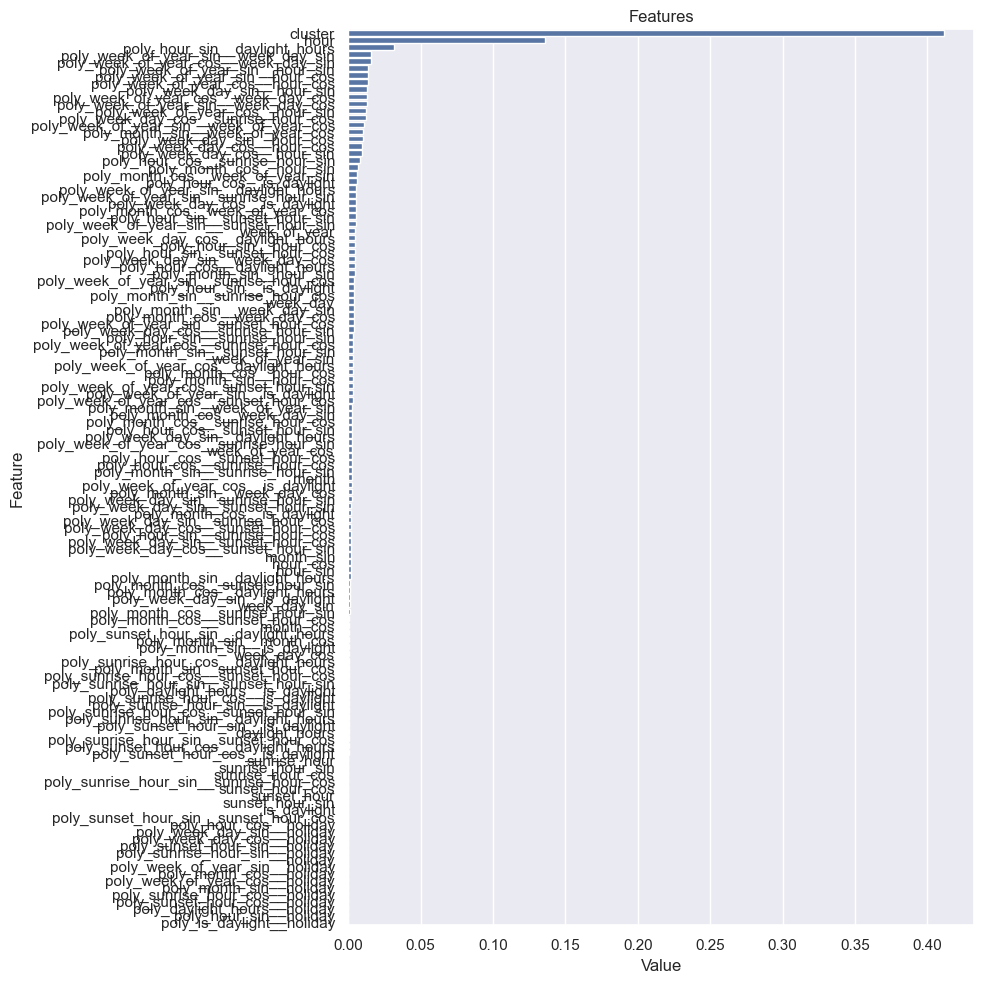

In [55]:
def plot_importance(rf, features, num=len(train_features), save=False):
    feature_imp = pd.DataFrame({'Value': rf.feature_importances_, 'Feature': feature_list})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf, train_features)

# Real predictions

## Changing sample_submission to make real predictions

The same process that we did for the training data but for the predictions features

In [56]:
real_test = pd.read_csv("/Users/Tomasss/uni/23_24Master/Modelos toma de decisión/entrega 1/maas-demand-in-madrid/data/sample_submission.csv")

In [59]:
split_columns= real_test["Id"].str.split("_", n = 3, expand = True)

real_test['cluster']= split_columns[0]

real_test['date']= split_columns[1]
real_test['date'] = pd.to_datetime(real_test['date'])

real_test['hour']= split_columns[2]
merged_df['hour'] = merged_df['fecha_hora'].dt.hour
real_test['hour'] = real_test['hour'].astype(int)

real_test['month'] = real_test['date'].dt.month

real_test=real_test.drop(columns=['trips','Id'])

real_test['week_of_year'] = real_test['date'].dt.isocalendar().week
real_test['week_day'] = real_test['date'].dt.day_of_week + 1

KeyError: 'Id'

In [61]:
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in real_test['date']
]

sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in real_test['date']
]

sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour}, 
                         index = real_test.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)

sun_light_features['is_daylight'] = np.where(
                                        (real_test['hour'] >= sun_light_features['sunrise_hour']) & \
                                        (real_test['hour'] < sun_light_features['sunset_hour']),
                                        1,
                                        0
                                    )

In [62]:
real_test = pd.concat([
                            real_test,
                            sun_light_features,
                        ], axis=1)

In [63]:
#real_test.drop('Id',axis=1)

In [64]:
madrid_holidays_test = ['2022-01-01', '2022-01-06', '2022-04-15', '2022-05-01', '2022-08-15', '2022-10-12','2022-11-09', '2022-11-01', '2022-12-06','2022-12-08', '2022-12-26']
real_test['holiday'] = 0
real_test.loc[real_test['date'].isin(madrid_holidays), 'holiday'] = 1

In [66]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding_test(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.
      
    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(real_test['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(real_test['week_of_year'], cycle_length=52)
week_day_encoded = cyclical_encoding(real_test['week_day'], cycle_length=7)
hour_day_encoded = cyclical_encoding(real_test['hour'], cycle_length=24)
sunrise_hour_encoded = cyclical_encoding(real_test['sunrise_hour'], cycle_length=24)
sunset_hour_encoded = cyclical_encoding(real_test['sunset_hour'], cycle_length=24)

cyclical_features_test = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_encoded,
                        sunrise_hour_encoded,
                        sunset_hour_encoded
                    ], axis=1)

real_test = pd.concat([
                            real_test,
                            cyclical_features,
                        ], axis=1)

In [67]:
# Interaction between exogenous variables
# ==============================================================================
transformer_poly_test = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False
                   ).set_output(transform="pandas")

poly_cols = [
    'month_sin', 
    'month_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'week_day_sin',
    'week_day_cos',
    'hour_sin',
    'hour_cos',
    'sunrise_hour_sin',
    'sunrise_hour_cos',
    'sunset_hour_sin',
    'sunset_hour_cos',
    'daylight_hours',
    'is_daylight',
    'holiday'
]

poly_features = transformer_poly_test.fit_transform(real_test[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")
real_test = pd.concat([real_test, poly_features], axis=1)

In [68]:
#real_test = real_test.drop(['Id','date'],axis=1)

In [70]:
real_test = real_test.dropna()

In [73]:
real_test['cluster'] = real_test['cluster'].astype(int)

/var/folders/kf/nft7rg5x6rqdbzmj8vwszrhr0000gp/T/ipykernel_2448/1098912090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_test['cluster'] = real_test['cluster'].astype(int)


# Predicting

Training with all the data

In [77]:
rf.fit(features, labels)

RandomForestRegressor(random_state=42)

Predicting

In [81]:
real_test = real_test.drop('date',axis=1)

In [83]:
real_test_features = np.array(real_test)
REAL_predictions = rf.predict(real_test_features)

In [84]:
real_test['prediction'] = REAL_predictions

In [85]:
submission_RF = pd.read_csv("data/sample_submission.csv")
submission_RF['trips'] = real_test['prediction']
submission_RF

,Id,trips
0,72_2022-09-30_22,1.62
1,93_2022-09-30_22,0.84
2,36_2022-09-30_22,1.48
3,83_2022-09-30_22,0.66
4,92_2022-09-30_22,2.08
...,...,...
131833,45_2023-01-01_00,0.90
131834,59_2023-01-01_00,2.78
131835,25_2023-01-01_00,1.78
131836,37_2023-01-01_00,1.82


In [86]:
submission_RF.to_csv('submission_RF_1.csv',index=False)

This gave us a 1.803 MAE on kaggle